# Word2Vec (Negative Sampling)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
np.__version__, torch.__version__

('1.26.4', '2.4.1+cu118')

In [4]:
import matplotlib
matplotlib.__version__

'3.9.2'

## 1. Load data

In [5]:
import nltk
from nltk.corpus import brown
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [6]:
corpus = brown.sents(categories='news')

In [7]:
corpus = [sent for sent in corpus if len(sent) > 2]
corpus

[['The',
  'Fulton',
  'County',
  'Grand',
  'Jury',
  'said',
  'Friday',
  'an',
  'investigation',
  'of',
  "Atlanta's",
  'recent',
  'primary',
  'election',
  'produced',
  '``',
  'no',
  'evidence',
  "''",
  'that',
  'any',
  'irregularities',
  'took',
  'place',
  '.'],
 ['The',
  'jury',
  'further',
  'said',
  'in',
  'term-end',
  'presentments',
  'that',
  'the',
  'City',
  'Executive',
  'Committee',
  ',',
  'which',
  'had',
  'over-all',
  'charge',
  'of',
  'the',
  'election',
  ',',
  '``',
  'deserves',
  'the',
  'praise',
  'and',
  'thanks',
  'of',
  'the',
  'City',
  'of',
  'Atlanta',
  "''",
  'for',
  'the',
  'manner',
  'in',
  'which',
  'the',
  'election',
  'was',
  'conducted',
  '.'],
 ['The',
  'September-October',
  'term',
  'jury',
  'had',
  'been',
  'charged',
  'by',
  'Fulton',
  'Superior',
  'Court',
  'Judge',
  'Durwood',
  'Pye',
  'to',
  'investigate',
  'reports',
  'of',
  'possible',
  '``',
  'irregularities',
  "''",
 

In [8]:
#2. numeralization
#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(corpus))) #all the words we have in the system - <UNK>

In [9]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}
word2index['dog']

8895

In [10]:
vocabs.append('<UNK>')
word2index['<UNK>'] = 0

In [11]:
index2word = {v:k for k, v in word2index.items()}
index2word[5]

'craftsmen'

## 2. Prepare train data

In [12]:
def random_batch(batch_size, corpus, window_size=2):
    
    # Make skip gram of one size window
    skip_grams = []
    # loop each word sequence
    # we starts from 1 because 0 has no context
    # we stop at second last for the same reason
    for sent in corpus:
        if len(sent) > 2 * window_size:
                
            for i in range(window_size, len(sent) - window_size):
                target = word2index[sent[i]]
                
                for j in range(-window_size, window_size+1):
                    if j!=0:
                        outside = word2index[sent[i+j]]
                        skip_grams.append([target, outside])
    
    # print(f"Generated {len(skip_grams)} skip-grams with window size {window_size}")

    if len(skip_grams) == 0:
        raise ValueError("No skip-grams generated. Check the corpus and window size")

    
     # Randomly sample a batch of skip-grams
    random_indices = np.random.choice(len(skip_grams), batch_size, replace=False)
    inputs = np.array([skip_grams[i][0] for i in random_indices])
    labels = np.array([skip_grams[i][1] for i in random_indices])
            
    return inputs.reshape(-1, 1), labels.reshape(-1, 1)

In [13]:
x, y = random_batch(2, corpus)

x.shape  #batch_size, 1


(2, 1)

In [14]:
x

array([[9202],
       [7067]])

In [15]:
y.shape  #batch_size 1

(2, 1)

## 3. Negative Sampling

### Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

In [16]:
z = 0.001

In [17]:
#count
from collections import Counter

word_count = Counter(flatten(corpus))
word_count

#get the total number of words
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

100351

In [18]:
vocabs

['tax-exemption',
 'depositors',
 'suburb',
 'discuss',
 'tasks',
 'craftsmen',
 'Mercer',
 'Yes',
 "wasn't",
 'jumped',
 "Collins'",
 'anti-trust',
 'major-league',
 'guttural',
 'Hutchins',
 'Shiflett',
 'Stadium',
 'Ocean',
 'requirement',
 'misses',
 'premier',
 'allowances',
 'Champion',
 'libraries',
 "President's",
 'escaped',
 'standing',
 'members',
 'buried',
 'doings',
 'inspiring',
 'everyone',
 'application',
 'promotion',
 'Bowl',
 'viewers',
 '420',
 'guard',
 'fuel',
 'Emilio',
 'forced',
 'intangible',
 'exciting',
 'exempt',
 'understates',
 'implicit',
 'lots',
 'Ponce',
 "armory's",
 'ugly',
 'rely',
 'Jurisdiction',
 'McEachern',
 'Kirkland',
 'dervishes',
 "SMU's",
 'natural',
 'Tigard',
 'Lockheed',
 'flourishes',
 'no',
 'active',
 '$8,250',
 'vice-president',
 'populous',
 'denunciation',
 'Carey',
 'menu',
 'Raesz',
 'dazzler',
 'biz',
 'Johnson',
 'injury',
 'Assisting',
 'voiced',
 'Grapefruit',
 'Saledo',
 'makers',
 'towering',
 'landscape',
 'Soule',
 'en

$$P(w)=U(w)^{3/4}/Z$$

In [19]:
unigram_table = []

for v in vocabs:
    uw = word_count[v] / num_total_words
    uw_alpha = int((uw ** 0.75) / z)
    unigram_table.extend([v] * uw_alpha)
    
Counter(unigram_table)

Counter({'the': 114,
         ',': 108,
         '.': 89,
         'of': 69,
         'to': 55,
         'and': 55,
         'a': 52,
         'in': 50,
         'for': 30,
         'that': 26,
         'The': 26,
         '``': 24,
         "''": 24,
         'is': 24,
         'was': 24,
         'on': 23,
         'at': 21,
         'with': 20,
         'be': 19,
         'as': 18,
         'by': 18,
         'he': 17,
         'his': 15,
         'said': 15,
         'will': 15,
         'it': 14,
         'from': 14,
         ';': 13,
         'are': 13,
         'has': 12,
         'had': 12,
         'an': 12,
         '--': 12,
         'this': 11,
         'who': 11,
         'were': 11,
         'not': 11,
         'Mrs.': 11,
         'have': 11,
         'would': 10,
         'which': 10,
         'their': 10,
         'they': 9,
         'He': 9,
         'been': 9,
         'out': 8,
         'more': 8,
         'all': 8,
         'one': 8,
         'I': 8,
         'Mr.'

## 4. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [20]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs)

In [21]:
import random

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []
    for i in range(batch_size):  #(1, k)
        target_index = targets[i].item()
        nsample      = []
        while (len(nsample) < k):
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))
        
    return torch.cat(neg_samples) #batch_size, k

In [22]:
batch_size = 128
window_size = 4
x, y = random_batch(batch_size, corpus, window_size )
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)

In [23]:
k = 5
neg_samples = negative_sampling(y_tensor, unigram_table, k)

In [24]:
y_tensor[1]

tensor([11956])

In [25]:
neg_samples[1]

tensor([9946, 8789, 6894, 5621, 1287])

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [26]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()
    
    def forward(self, center, outside, negative):
        #center, outside:  (bs, 1)
        #negative       :  (bs, k)
        
        center_embed   = self.embedding_center(center) #(bs, 1, emb_size)
        outside_embed  = self.embedding_outside(outside) #(bs, 1, emb_size)
        negative_embed = self.embedding_outside(negative) #(bs, k, emb_size)
        
        uovc           = outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, 1)
        ukvc           = -negative_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1, 1) #(bs, 1)
        
        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)
        
        return -torch.mean(loss)

In [27]:
#test your model
emb_size = 2
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size)

In [28]:
loss = model(x_tensor, y_tensor, neg_samples)

In [29]:
loss

tensor(2.1803, grad_fn=<NegBackward0>)

## 5. Training

In [30]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_min = int(elapsed_time / 60)
    elapsed_sec = int(elapsed_time - (elapsed_min * 60))
    return elapsed_min, elapsed_sec

In [33]:
import time
num_epochs = 500
batch_size = 128
window_sizes = [2,4,5,6,8,10]

for window_size in window_sizes:
    print(f"Training with window size = {window_size}\n")

    for epoch in range(num_epochs):
        start = time.time()
        
        #get batch
        input_batch, label_batch = random_batch(batch_size, corpus)
        input_tensor = torch.LongTensor(input_batch)
        label_tensor = torch.LongTensor(label_batch)
        
        #predict
        neg_samples = negative_sampling(label_tensor, unigram_table, k)
        loss = model(input_tensor, label_tensor, neg_samples)
        
        #backprogate
        optimizer.zero_grad()
        loss.backward()
        
        #update alpha
        optimizer.step()

        end = time.time()
        epoch_mins, epoch_sec = epoch_time(start, end)
        
        #print the loss
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f} | time: {epoch_mins}m {epoch_sec}s")
    
    print(f"Completed training with window size: {window_size}\n")

Training with window size = 2

Epoch    100 | Loss: 1.829350 | time: 0m 0s
Epoch    200 | Loss: 1.951559 | time: 0m 0s
Epoch    300 | Loss: 1.897569 | time: 0m 0s
Epoch    400 | Loss: 2.141865 | time: 0m 0s
Epoch    500 | Loss: 1.956091 | time: 0m 0s
Completed training with window size: 2

Training with window size = 4

Epoch    100 | Loss: 1.909040 | time: 0m 0s
Epoch    200 | Loss: 1.957619 | time: 0m 0s
Epoch    300 | Loss: 1.758559 | time: 0m 0s
Epoch    400 | Loss: 1.936316 | time: 0m 0s
Epoch    500 | Loss: 1.811992 | time: 0m 0s
Completed training with window size: 4

Training with window size = 5

Epoch    100 | Loss: 1.946412 | time: 0m 0s
Epoch    200 | Loss: 1.715005 | time: 0m 0s
Epoch    300 | Loss: 1.661690 | time: 0m 0s
Epoch    400 | Loss: 1.704341 | time: 0m 0s
Epoch    500 | Loss: 1.663925 | time: 0m 0s
Completed training with window size: 5

Training with window size = 6

Epoch    100 | Loss: 1.846527 | time: 0m 0s
Epoch    200 | Loss: 1.592641 | time: 0m 0s
Epoch   

## 6. Plot the embeddings

In [34]:
vocabs

['tax-exemption',
 'depositors',
 'suburb',
 'discuss',
 'tasks',
 'craftsmen',
 'Mercer',
 'Yes',
 "wasn't",
 'jumped',
 "Collins'",
 'anti-trust',
 'major-league',
 'guttural',
 'Hutchins',
 'Shiflett',
 'Stadium',
 'Ocean',
 'requirement',
 'misses',
 'premier',
 'allowances',
 'Champion',
 'libraries',
 "President's",
 'escaped',
 'standing',
 'members',
 'buried',
 'doings',
 'inspiring',
 'everyone',
 'application',
 'promotion',
 'Bowl',
 'viewers',
 '420',
 'guard',
 'fuel',
 'Emilio',
 'forced',
 'intangible',
 'exciting',
 'exempt',
 'understates',
 'implicit',
 'lots',
 'Ponce',
 "armory's",
 'ugly',
 'rely',
 'Jurisdiction',
 'McEachern',
 'Kirkland',
 'dervishes',
 "SMU's",
 'natural',
 'Tigard',
 'Lockheed',
 'flourishes',
 'no',
 'active',
 '$8,250',
 'vice-president',
 'populous',
 'denunciation',
 'Carey',
 'menu',
 'Raesz',
 'dazzler',
 'biz',
 'Johnson',
 'injury',
 'Assisting',
 'voiced',
 'Grapefruit',
 'Saledo',
 'makers',
 'towering',
 'landscape',
 'Soule',
 'en

In [35]:
laws = torch.LongTensor([word2index['laws']])
laws

tensor([8150])

In [36]:
laws_embed_c = model.embedding_center(laws)
laws_embed_o = model.embedding_outside(laws)
laws_embed   = (laws_embed_c + laws_embed_o) / 2
laws_embed

tensor([[-0.2986,  0.2313]], grad_fn=<DivBackward0>)

In [37]:
laws_embed_o

tensor([[-0.5911,  0.0308]], grad_fn=<EmbeddingBackward0>)

In [38]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([word2index[word]])
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

In [39]:
get_embed('laws')

(-0.2986360192298889, 0.23129580914974213)

In [40]:
get_embed('although')

(0.4552623927593231, -0.4539295434951782)

In [41]:
get_embed('Heights')

(0.6874531507492065, 1.4663821458816528)

In [42]:
get_embed('disallowed')

(-0.29341647028923035, 0.3157719075679779)

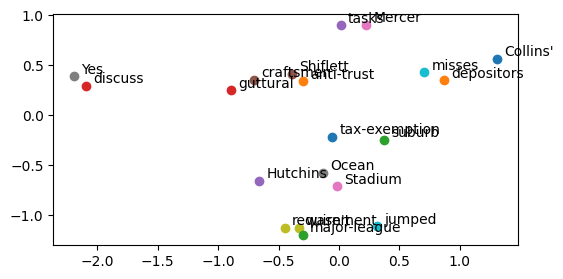

In [43]:
plt.figure(figsize=(6, 3))
for i, word in enumerate(vocabs[:20]):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [44]:
def get_embed(word):
    """
    Get the full embedding vector for a given word from your trained GloVe model.
    Args:
        word (str): The word for which to retrieve the embedding.
    Returns:
        np.ndarray: The full embedding vector for the word.
    """
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']  # Use '<UNK>' embedding for unknown words
    
    word_tensor = torch.LongTensor([index])
    
    # Retrieve embeddings
    embed_c = model.embedding_center(word_tensor)
    embed_o = model.embedding_outside(word_tensor)
    embed = (embed_c + embed_o) / 2  # Average center and context embeddings
    
    return embed.detach().numpy()[0]  # Return full vector as a NumPy array


In [45]:
# Dictionary to store word embeddings
word_vectors = {}

# Retrieve embeddings for all words in the vocabulary
for word in vocabs:
    word_vectors[word] = get_embed(word)

# Example: Check the embedding for a specific word
print("Embedding for 'king':", word_vectors.get('king', 'Not in vocabulary'))


Embedding for 'king': [-0.12787586 -0.17600203]


In [46]:
word_vectors

{'tax-exemption': array([-0.05412496, -0.21912467], dtype=float32),
 'depositors': array([0.8672408 , 0.34783894], dtype=float32),
 'suburb': array([ 0.37140223, -0.24636848], dtype=float32),
 'discuss': array([-2.092819  ,  0.29303473], dtype=float32),
 'tasks': array([0.01522487, 0.89893496], dtype=float32),
 'craftsmen': array([-0.69984543,  0.35175443], dtype=float32),
 'Mercer': array([0.2263291, 0.9045677], dtype=float32),
 'Yes': array([-2.1888065 ,  0.39051425], dtype=float32),
 "wasn't": array([-0.33290958, -1.1304752 ], dtype=float32),
 'jumped': array([ 0.31757313, -1.1153708 ], dtype=float32),
 "Collins'": array([1.3086466 , 0.56318176], dtype=float32),
 'anti-trust': array([-0.2942957 ,  0.34084392], dtype=float32),
 'major-league': array([-0.30211633, -1.1990068 ], dtype=float32),
 'guttural': array([-0.8928838 ,  0.24747315], dtype=float32),
 'Hutchins': array([-0.6589931 , -0.65968806], dtype=float32),
 'Shiflett': array([-0.38623786,  0.41304505], dtype=float32),
 'Sta

In [47]:
# Load the dataset and split into semantic and syntactic subsets
def load_dataset(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    semantic_questions = []
    syntactic_questions = []
    current_section = None  # Initialize current_section

    for line in lines:
        if line.startswith(": capital-common-countries"):
            current_section = "semantic"
        elif line.startswith(": past-tense"):
            current_section = "syntactic"
        elif line.startswith(":"):
            current_section = None  # Reset for unrelated sections
        elif current_section == "semantic":
            semantic_questions.append(line.strip())
        elif current_section == "syntactic":
            syntactic_questions.append(line.strip())
    
    return semantic_questions, syntactic_questions

In [49]:
# Negatvie Sampling
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def calculate_accuracy(questions, embedding_model, word2index):
    """
    Calculate accuracy for analogy questions.
    
    Args:
        questions (list): List of analogy questions in format 'a b c d'.
        embedding_model: Trained SkipgramNeg model.
        word2index (dict): Mapping of words to their indices.
    
    Returns:
        float: Accuracy as a percentage.
    """
    correct = 0
    total = 0

    for question in questions:
        try:
            a, b, c, d = question.split()
            if a in word2index and b in word2index and c in word2index and d in word2index:
                a_idx = word2index[a]
                b_idx = word2index[b]
                c_idx = word2index[c]

                # Vector arithmetic: b - a + c
                vec_b = embedding_model.embedding_center.weight[b_idx].detach().numpy()
                vec_a = embedding_model.embedding_center.weight[a_idx].detach().numpy()
                vec_c = embedding_model.embedding_center.weight[c_idx].detach().numpy()

                target_vector = vec_b - vec_a + vec_c

                # Find closest word using cosine similarity
                all_vectors = embedding_model.embedding_center.weight.detach().numpy()
                similarities = cosine_similarity(target_vector.reshape(1, -1), all_vectors)
                predicted_idx = np.argmax(similarities)
                predicted_word = list(word2index.keys())[list(word2index.values()).index(predicted_idx)]

                if predicted_word == d:
                    correct += 1
                total += 1
        except Exception as e:
            continue  # Skip any malformed questions or missing words

    return (correct / total) * 100 if total > 0 else 0





In [50]:
# Load semantic and syntactic questions
semantic_questions, syntactic_questions = load_dataset("word-test.v1.txt")

# Calculate accuracies
semantic_accuracy = calculate_accuracy(semantic_questions, model, word2index)
syntactic_accuracy = calculate_accuracy(syntactic_questions, model, word2index)

print(f"Semantic Accuracy: {semantic_accuracy:.2f}%")
print(f"Syntactic Accuracy: {syntactic_accuracy:.2f}%")

Semantic Accuracy: 0.00%
Syntactic Accuracy: 0.00%


## 7. Cosine similarity

In [46]:
laws = get_embed('laws')
laws

(0.43906575441360474, -0.11203426867723465)

In [47]:
although = get_embed('although')
although

(0.4447695314884186, -0.325581818819046)

In [48]:
Heights = get_embed('Heights')
Heights

(-0.0636206865310669, 0.6180993914604187)

In [49]:
np.array(laws) @ np.array(although)

np.float64(0.23175939084914376)

In [50]:
#more formally is to divide by its norm
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

print(cosine_similarity(np.array(laws), np.array(although)))
print(cosine_similarity(np.array(laws), np.array(although)))

0.9278975944812892
0.9278975944812892


In [51]:
def load_similarity_dataset(filepath):
    """
    Load the WordSim similarity dataset.
    Args:
        filepath (str): Path to the dataset file.
    Returns:
        list: List of tuples (word1, word2, human_score).
    """
    pairs = []
    with open(filepath, "r") as f:
        lines = f.readlines()
        for line in lines:
            word1, word2, score = line.strip().split()
            pairs.append((word1, word2, float(score)))
    return pairs

In [52]:
# Question 3
# Example: Load `wordsim_similarity_goldstandard`
similarity_dataset = load_similarity_dataset("wordsim353/wordsim_similarity_goldstandard.txt")
print(f"Loaded {len(similarity_dataset)} word pairs from the dataset.")

Loaded 203 word pairs from the dataset.


In [53]:
similarity_dataset

[('tiger', 'cat', 7.35),
 ('tiger', 'tiger', 10.0),
 ('plane', 'car', 5.77),
 ('train', 'car', 6.31),
 ('television', 'radio', 6.77),
 ('media', 'radio', 7.42),
 ('bread', 'butter', 6.19),
 ('cucumber', 'potato', 5.92),
 ('doctor', 'nurse', 7.0),
 ('professor', 'doctor', 6.62),
 ('student', 'professor', 6.81),
 ('smart', 'stupid', 5.81),
 ('wood', 'forest', 7.73),
 ('money', 'cash', 9.15),
 ('king', 'queen', 8.58),
 ('king', 'rook', 5.92),
 ('bishop', 'rabbi', 6.69),
 ('fuck', 'sex', 9.44),
 ('football', 'soccer', 9.03),
 ('football', 'basketball', 6.81),
 ('football', 'tennis', 6.63),
 ('Arafat', 'Jackson', 2.5),
 ('physics', 'chemistry', 7.35),
 ('vodka', 'gin', 8.46),
 ('vodka', 'brandy', 8.13),
 ('drink', 'eat', 6.87),
 ('car', 'automobile', 8.94),
 ('gem', 'jewel', 8.96),
 ('journey', 'voyage', 9.29),
 ('boy', 'lad', 8.83),
 ('coast', 'shore', 9.1),
 ('asylum', 'madhouse', 8.87),
 ('magician', 'wizard', 9.02),
 ('midday', 'noon', 9.29),
 ('furnace', 'stove', 8.79),
 ('food', 'frui

In [54]:
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error
import numpy as np



# Function to compute model similarity using dot product
def compute_model_similarity(word_vectors, similarity_dataset):
    """
    Compute model similarity for word pairs using dot product.
    Args:
        word_vectors (dict): Dictionary mapping words to their embeddings.
        similarity_dataset (list): List of tuples (word1, word2, human_score).
    Returns:
        tuple: List of model scores and human similarity scores.
    """
    model_scores = []
    human_scores = []

    for word1, word2, human_score in similarity_dataset:
        if word1 in word_vectors and word2 in word_vectors:
            vec1 = word_vectors[word1]
            vec2 = word_vectors[word2]
            model_score = np.dot(vec1, vec2)  # Dot product as similarity
            model_scores.append(model_score)
            human_scores.append(human_score)
        else:
            print(f"Skipping pair ({word1}, {word2}): Out of vocabulary")

    return model_scores, human_scores
   


In [55]:


    # Example: Load word vectors (replace with your trained model's word_vectors)
    # word_vectors should be a dictionary mapping words to their embeddings

    # Compute model and human similarity scores
model_scores, human_scores = compute_model_similarity(word_vectors, similarity_dataset)

    # Calculate Spearman correlation
correlation, p_value = spearmanr(model_scores, human_scores)
print(f"Spearman Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

    # Optional: Calculate MSE
mse = mean_squared_error(human_scores, model_scores)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Skipping pair (tiger, cat): Out of vocabulary
Skipping pair (tiger, tiger): Out of vocabulary
Skipping pair (media, radio): Out of vocabulary
Skipping pair (cucumber, potato): Out of vocabulary
Skipping pair (smart, stupid): Out of vocabulary
Skipping pair (king, rook): Out of vocabulary
Skipping pair (bishop, rabbi): Out of vocabulary
Skipping pair (fuck, sex): Out of vocabulary
Skipping pair (football, soccer): Out of vocabulary
Skipping pair (Arafat, Jackson): Out of vocabulary
Skipping pair (vodka, gin): Out of vocabulary
Skipping pair (vodka, brandy): Out of vocabulary
Skipping pair (drink, eat): Out of vocabulary
Skipping pair (gem, jewel): Out of vocabulary
Skipping pair (journey, voyage): Out of vocabulary
Skipping pair (coast, shore): Out of vocabulary
Skipping pair (asylum, madhouse): Out of vocabulary
Skipping pair (magician, wizard): Out of vocabulary
Skipping pair (midday, noon): Out of vocabulary
Skipping pair (furnace, stove): Out of vocabulary
Skipping pair (food, fruit

In [61]:
print("Model Score vs Human Score\n")
print(model_scores)
print(human_scores)

Model Score vs Human Score

[0.12284297, 1.1371572, 1.2779886, -0.24161938, 0.09499461, -0.15696669, -0.067165256, 0.025619686, -0.1498121, 0.0942335, 1.1946412, -0.35115603, -0.8450347, -0.1732961, -0.6726641, 0.15516813, 0.75010395, 0.1314617, 0.07552831, 1.0175548, -0.1473388, -0.21967904, -0.21897456, -0.4542359, -0.153946, 1.6471256, -0.3033598, -0.13967794, -0.031161733, 1.0461764, 0.3667919, 0.59109217, 0.62461483, 0.54138076, -0.5835937, -0.5454409, -0.04526688, 0.122270055, -0.89762336, -0.36097363, -1.1723938, 0.400675, 0.30148056, 0.060533434, -0.18986562, 0.13964, 0.25843063, -0.83639044, 0.21663937, 0.07525872, -0.17402536, -0.030287005, -0.22667342, -0.65512794, 0.22725147, -0.014169633, -0.032948118, -0.19371459, -0.02295199, -1.2365694, 0.56328124, -0.06301203, -0.04736501, -0.1898584, -0.34494707, 0.19127962, 0.061260153, -0.45257264, 0.09119642, 0.21987906, -0.67048585, 0.6075078, -0.655835, -0.04565613, -0.039996795, 1.2353163, -0.5022758, -0.017762586, 0.61452675, -